## Charmonia Primordial Suppression in pPb Collision

## Load & Preprocess Datafiles

### Imports & Data Loading

In [1]:
# --- imports & search path ---
import sys
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

project = Path.cwd()
sys.path.insert(0, str(project / "combined_code"))

from primordial_module import (
    ReaderConfig, build_ensemble, make_bins_from_width, Style,
    Y_WINDOW_FORWARD, Y_WINDOW_BACKWARD, Y_WINDOW_CENTRAL
)

# ---------- I/O ----------
outdir = project / "primordial_output_combined"
outdir.mkdir(exist_ok=True, parents=True)

# ---------- inputs: (form, energy, model) -> base prefix (containing <base>_tau1/_tau2/)
PATHS = {
    "new": {
        (8.16, "Pert"):  project / "input/primordial/pPb8TeV/output_new_form/output_8pPb_Tf170_Pert",
        (8.16, "NPWLC"): project / "input/primordial/pPb8TeV/output_new_form/output_8pPb_Tf170_NPWLC",
        (5.02, "Pert"):  project / "input/primordial/pPb5TeV/output_new_form/output_5pPb_Tf170_Pert",
        (5.02, "NPWLC"): project / "input/primordial/pPb5TeV/output_new_form/output_5pPb_Tf170_NPWLC",
    },
    "old": {
        (8.16, "Pert"):  project / "input/primordial/pPb8TeV/output_old_form/output_8pPb_Tf170_Pert",
        (8.16, "NPWLC"): project / "input/primordial/pPb8TeV/output_old_form/output_8pPb_Tf170_NPWLC",
        (5.02, "Pert"):  project / "input/primordial/pPb5TeV/output_old_form/output_5pPb_Tf170_Pert",
        (5.02, "NPWLC"): project / "input/primordial/pPb5TeV/output_old_form/output_5pPb_Tf170_NPWLC",
    },
}
glauber = {8.16: project / "input/glauber_data/8TeV",
           5.02: project / "input/glauber_data/5TeV"}

In [32]:
# --- Formation-times (in fm) for charmonium states ---
# new: 1/E_b – 2/E_b; old: previous perturbative-based τ_form range

TAUFORM_NEW = {
    "jpsi_1S":  (0.31, 0.62),   # 1/E_b – 2/E_b
    "chicJ_1P": (1.20, 2.40),
    "psi_2S":   (4.50, 9.00),
}

TAUFORM_OLD = {
    "jpsi_1S":  (1.00, 1.25),
    "chicJ_1P": (1.50, 1.875),
    "psi_2S":   (2.50, 3.125),
}

STATE_SHORT = {
    "jpsi_1S":  "1S",
    "chicJ_1P": "1P",
    "psi_2S":   "2S",
}

In [2]:
## -- Cosmetics
# ---------- visual style ----------
Style.apply()
mpl.rcParams.update({
    "font.size": 11,
    "xtick.major.size": 6, "ytick.major.size": 6,
    "xtick.minor.size": 3, "ytick.minor.size": 3,
    # TeX-like math without requiring LaTeX:
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "axes.unicode_minus": False,
    # legend polish
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.framealpha": 0.9,
    "legend.borderpad": 0.6,
    "legend.handlelength": 2.2,
})

# Labels
STATE_LABELS = {"jpsi_1S": r"$J/\psi(1S)$", "chicJ_1P": r"$\chi_c(1P)$", "psi_2S": r"$\psi(2S)$"}

# Colors (model-coded by default)
MODEL_COLORS = {"Pert": "tab:blue", "NPWLC": "tab:red"}       # blue vs red
STATE_COLORS = {"jpsi_1S": "C0", "chicJ_1P": "C1", "psi_2S": "C2"}  # when color_by="state"

# Center-line linestyle by model (used when not comparing energy/τ)
MODEL_LS = {"Pert": "-", "NPWLC": "--"}

# For state comparisons (keep same color = model color, vary linestyle)
STATE_LS = {"jpsi_1S": "-", "psi_2S": "--", "chicJ_1P": ":"}

# Comparison encodings (consistent across all plots)
# Energy: 5.02 TeV = dashed center + hatched band; 8.16 TeV = solid center + solid band
ENERGY_EDGE_LS = {5.02: "--", 8.16: "-"}
FORM_EDGE_LS   = {"new": "-", "old": "--"}        # τ(new) solid; τ(old) dashed
FORM_ALPHA     = {"new": 0.26, "old": 0.14}       # band fill opacities
EDGE_ALPHA     = 0.9
EDGE_LW        = 1.2
ENERGY_HATCH   = {5.02: "xx", 8.16: ""}           # empty string = no hatch (avoids deprecation)
FORM_HATCH     = {"new": "", "old": "xx"}
HATCH_EDGE_ALPHA = 0.25

# ---------- physics binning ----------
Y_BINS    = make_bins_from_width(-5.0, 5.0, 0.5)
PT_BINS   = make_bins_from_width(0.0, 20.0, 2.5)
PT_WINDOW = (0.0, 20.0)
Y_WINS    = {"forward": Y_WINDOW_FORWARD, "backward": Y_WINDOW_BACKWARD, "central": Y_WINDOW_CENTRAL}
CENT_CLASSES = [(0,10), (10,20), (20,40), (40,60), (60,80), (80,100)]
# CENT_CLASSES = [(0, 20), (20,40), (40,60), (60,80), (80,100)]

cfg = ReaderConfig(debug=False)

In [3]:
# ---------- load helpers ----------
@dataclass
class Combo:
    energy: float
    model: str
    form: str
    ens: object
    runs: dict

def _try_build(base_prefix: Path, glauber_root: Path, sqrts: float):
    try:
        return build_ensemble(str(base_prefix), str(glauber_root),
                              tags=("tau1","tau2"), cfg=cfg, sqrts_NN=float(sqrts))
    except FileNotFoundError as e:
        print(f"[WARN] Missing: {e}")
        return None, None

def load_all():
    found = []
    for form, mapping in PATHS.items():
        for (energy, model), base in mapping.items():
            ens, runs = _try_build(base, glauber[energy], energy)
            if ens is not None:
                found.append(Combo(energy, model, form, ens, runs))
    assert found, "No primordial inputs found."
    return found

present = load_all()

### Plotting Helpers

In [164]:
# ---------- tiny utils ----------
def _corner(ax, text, loc="tr"):
    pos = {"tl":(0.02,0.98),"tr":(0.98,0.98),"bl":(0.02,0.02),"br":(0.98,0.02)}[loc]
    ha = "left" if "l" in loc else "right"; va = "top" if "t" in loc else "bottom"
    ax.text(pos[0], pos[1], text, transform=ax.transAxes, ha=ha, va=va,
            fontsize=10, bbox=dict(facecolor="white", alpha=0.85, edgecolor="none"))

def _edges_from_centers(centers, lo=None, hi=None):
    """Robust histogram edges from arbitrary bin centers (handles irregular spacing)."""
    c = np.sort(np.unique(np.asarray(centers, float)))
    if c.size == 0: return np.array([0.0, 1.0], float)
    if c.size == 1:
        left, right = c[0]-0.5, c[0]+0.5
        if lo is not None: left = lo
        if hi is not None: right = hi
        return np.array([left, right], float)
    mids = 0.5*(c[1:]+c[:-1])
    e = np.r_[c[0] - (mids[0]-c[0]), mids, c[-1] + (c[-1]-mids[-1])]
    if lo is not None: e[0]  = lo
    if hi is not None: e[-1] = hi
    return e


def _pick_color(state, model, *, color_by="model"):
    return STATE_COLORS[state] if color_by=="state" else MODEL_COLORS[model]

def _state_handles(states):
    return [Line2D([0],[0], color=STATE_COLORS[s], lw=2, linestyle=STATE_LS.get(s,"-"),
                   label=STATE_LABELS[s]) for s in states]

def _tauform_label(form: str, states) -> str:
    """
    Compact label like:
      τ_form^new [fm]: 1S 0.31–0.62, 1P 1.2–2.4, 2S 4.5–9.0
    Only includes states that are actually plotted.
    """
    if form == "new":
        mapping = TAUFORM_NEW
        prefix = r"$\tau_{\rm form}^{\rm new}$ [fm]: "
    elif form == "old":
        mapping = TAUFORM_OLD
        prefix = r"$\tau_{\rm form}^{\rm old}$ [fm]: "
    else:
        return ""

    pieces = []
    for s in states:
        if s in mapping and s in STATE_SHORT:
            lo, hi = mapping[s]
            pieces.append(f"{STATE_SHORT[s]}, {lo:.4g}–{hi:.4g}")
    return prefix + ", ".join(pieces) if pieces else ""

def _annotate_tauform_single_form(ax, combos, states, loc="bl"):
    """
    For figures where all combos share the same 'form' (only new or only old),
    add a single τ_form label block in the chosen corner (default bottom-left).
    """
    forms = {c.form for c in combos}
    if len(forms) != 1:
        return
    form = next(iter(forms))
    text = _tauform_label(form, states)
    if not text:
        return

    pos = {"bl": (0.02, 0.02), "br": (0.98, 0.02)}[loc]
    ha = "left" if "l" in loc else "right"
    ax.text(
        pos[0], pos[1], text,
        transform=ax.transAxes, ha=ha, va="bottom",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
    )

def _combo_info_label(combos, include_model=True) -> str:
    """
    Build a compact label like:
      √s_NN = 8.16 TeV, NPWLC
    Uses only information that is common to all combos.
    """
    energies = sorted({c.energy for c in combos})
    models   = sorted({c.model for c in combos})

    parts = []
    if len(energies) == 1:
        parts.append(r"$\sqrt{s_{NN}}=" + f"{energies[0]:.2f}$ TeV")
    if include_model and len(models) == 1:
        parts.append(models[0])

    return ", ".join(parts)


# ---------- legend helpers (single legend, combined patch+line per item) ----------
def _style_handles_for(combos, vary_energy, vary_form, color_by, states=None):
    """
    Build a single legend:
      - For energy/τ comparisons: neutral band patch + black center line per item.
      - For model comparison: colored band+line per model.
      - Optionally add state lines if multiple states are plotted.
    """
    from matplotlib.legend_handler import HandlerTuple
    handles, labels = [], []
    handler_map = {tuple: HandlerTuple(ndivide=None)}

    models = sorted({c.model for c in combos})

    if vary_energy:
        for e in sorted({c.energy for c in combos}):
            patch = Patch(facecolor="0.7", alpha=0.18,
                          edgecolor=("k" if ENERGY_HATCH.get(e,"") else "none"),
                          hatch=ENERGY_HATCH.get(e,""))
            line  = Line2D([0],[0], color="k", lw=2, linestyle=ENERGY_EDGE_LS.get(e,"-"))
            handles.append((patch, line)); labels.append(f"{e:.2f} TeV")
    elif vary_form:
        for key, lab in [("new", r"$\tau$=new"), ("old", r"$\tau$=old")]:
            patch = Patch(facecolor="0.7", alpha=0.18,
                          edgecolor=("k" if FORM_HATCH.get(key,"") else "none"),
                          hatch=FORM_HATCH.get(key,""))
            line  = Line2D([0],[0], color="k", lw=2, linestyle=FORM_EDGE_LS.get(key,"-"))
            handles.append((patch, line)); labels.append(lab)
    else:
        # Model comparison: match plotted colors/linestyles
        for m in models:
            patch = Patch(facecolor=MODEL_COLORS[m], alpha=0.18, edgecolor="none")
            line  = Line2D([0],[0], color=MODEL_COLORS[m], lw=2, linestyle=MODEL_LS[m])
            handles.append((patch, line)); labels.append(m)

    # Add state info only if requested
    if states is not None and len(states) > 1:
        for s in states:
            handles.append(Line2D([0],[0], color=STATE_COLORS[s], lw=2, linestyle=STATE_LS.get(s,"-")))
            labels.append(STATE_LABELS[s])

    return handles, labels, handler_map

# ---------- centrality utilities ----------
def _maps_from_runs(runs_dict): return next(iter(runs_dict.values())).centrality

def _centrality_percent(maps, bvals):
    bvals = np.asarray(bvals, float)
    c = maps.b_to_c(bvals).astype(float)
    if np.isfinite(c).any():
        cmax = float(np.nanmax(c))
        if cmax <= 1.5: c *= 100.0
        elif cmax > 150: c /= (cmax/100.0)
    good = np.isfinite(c); span = (np.nanmax(c[good]) - np.nanmin(c[good])) if good.any() else 0.0
    if (not good.all()) or (span < 5.0):
        bu = np.unique(bvals); n = len(bu)
        centers = (np.arange(n) + 0.5) * (100.0 / max(1,n))
        order = np.argsort(bu)
        c = np.interp(bvals, bu[order], centers[order])
    return c

def prep_vs_x(combo, xcol):
    dc, db = combo.ens.central_and_band_vs_b(with_feeddown=True, use_nbin=True)
    maps = _maps_from_runs(combo.runs)
    if xcol == "b":
        pass
    elif xcol == "Ncoll":
        dc["Ncoll"] = maps.b_to_nbin(dc["b"].to_numpy())
        if db is not None: db["Ncoll"] = maps.b_to_nbin(db["b"].to_numpy())
    elif xcol == "Cent":
        dc["Cent"] = _centrality_percent(maps, dc["b"].to_numpy())
        if db is not None: db["Cent"] = _centrality_percent(maps, db["b"].to_numpy())
    else:
        raise ValueError("xcol must be 'b','Ncoll','Cent'")
    dc = dc.sort_values(xcol).reset_index(drop=True)
    if db is not None: db = db.sort_values(xcol).reset_index(drop=True)
    return dc, db

# -------------------------- core drawing (fixed) --------------------------
def _stepify(edges, vals):
    edges = np.asarray(edges, float); vals = np.asarray(vals, float)
    x = np.repeat(edges, 2)[1:-1]
    y = np.repeat(vals,  2)
    return x, y

def _band_from_edges(ax, edges, vlo, vhi, *, color, face_alpha, edge_ls="-", hatch=""):
    """
    Draw the uncertainty band with optional hatching (overlay patch).
    Keep band edges solid; encode comparison by hatch and center-line only.
    """
    x_lo, y_lo = _stepify(edges, vlo)
    x_hi, y_hi = _stepify(edges, vhi)

    # base fill
    ax.fill_between(x_lo, y_lo, y_hi, facecolor=color, alpha=face_alpha, edgecolor="none", zorder=1)

    # hatched overlay (if requested)
    if hatch and hatch.strip():
        verts = np.vstack([np.column_stack([x_lo, y_lo]),
                           np.column_stack([x_hi[::-1], y_hi[::-1]])])
        poly = mpl.patches.Polygon(
            verts, closed=True, facecolor=(1,1,1,0), edgecolor=color,
            hatch=hatch, linewidth=0.0, alpha=HATCH_EDGE_ALPHA, zorder=1.5
        )
        ax.add_patch(poly)

    # top/bottom edges (solid)
    ax.plot(x_lo, y_lo, color=color, lw=EDGE_LW, ls="-", alpha=EDGE_ALPHA, zorder=2)
    ax.plot(x_hi, y_hi, color=color, lw=EDGE_LW, ls="-", alpha=EDGE_ALPHA, zorder=2)

def _center_from_edges(ax, edges, v, *, color, linestyle):
    x, y = _stepify(edges, v)
    ax.plot(x, y, color=color, linestyle=linestyle, lw=2.0, zorder=3)
# -------------------------------------------------------------------------

# ---------- overlay for R_pA vs Cent / Ncoll / b ----------
def overlay_vs_x(ax, combos, *, xcol, states,
                 note=None, legend_kind="style",
                 state_legend_loc="lower right", style_legend_loc="upper left",
                 ylim=(0.35, 1.05), color_by="model"):
    vary_energy = len({c.energy for c in combos}) > 1
    vary_form   = len({c.form   for c in combos}) > 1

    for combo in combos:
        dc, db = prep_vs_x(combo, xcol)
        centers = dc[xcol].to_numpy()
        edges = _edges_from_centers(centers, 0.0, 100.0) if xcol=="Cent" else _edges_from_centers(centers)

        for s in states:
            col = _pick_color(s, combo.model, color_by=color_by)

            # center style + band hatch encode the comparison
            if vary_energy:
                center_ls = ENERGY_EDGE_LS.get(combo.energy, "-")
                band_hatch = ENERGY_HATCH.get(combo.energy, "")
            elif vary_form:
                center_ls = FORM_EDGE_LS.get(combo.form, "-")
                band_hatch = FORM_HATCH.get(combo.form, "")
            else:
                center_ls = MODEL_LS.get(combo.model,"-") if color_by!="model" or len(states)==1 else STATE_LS.get(s,"-")
                band_hatch = ""

            if db is not None and f"{s}_lo" in db:
                _band_from_edges(ax, edges, db[f"{s}_lo"].to_numpy(), db[f"{s}_hi"].to_numpy(),
                                 color=col, face_alpha=FORM_ALPHA.get(combo.form, 0.20),
                                 edge_ls="-", hatch=band_hatch)
            _center_from_edges(ax, edges, dc[s].to_numpy(), color=col, linestyle=center_ls)

    labels = {"b": r"$b$ [\mathrm{fm}]", "Ncoll": r"$N_{\mathrm{coll}}$", "Cent": "Centrality [%]"}
    ax.set_xlabel(labels[xcol]); ax.set_ylabel(r"$R_{pA}$"); ax.grid(False)
    if xcol == "Cent":
        ax.set_xlim(0, 100); ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    if ylim: ax.set_ylim(*ylim)

    # Note: if a single state is shown and the note doesn't already contain it, append it
    if note is None:
        note_text = _combo_info_label(combos, include_model=True)
    else:
        note_text = note
    if len(states) == 1:
        s_lab = STATE_LABELS[states[0]]
        if s_lab not in note_text:
            note_text = f"{note_text} — {s_lab}"
    if note_text:
        _corner(ax, note_text, loc="tr")

    # Legend control
    if legend_kind == "states" and len(states) > 1:
        ax.legend(handles=_state_handles(states), loc=state_legend_loc, fontsize=10)
    else:
        handles, lbls, hmap = _style_handles_for(combos, vary_energy, vary_form, color_by,
                                                 states=(states if legend_kind=="both" else None))
        if handles:
            ax.legend(handles=handles, labels=lbls, handler_map=hmap,
                      loc=style_legend_loc, frameon=True, fontsize=10)

# ---------- per-centrality aggregation for grids ----------
def _maps_from_runs(runs_dict): return next(iter(runs_dict.values())).centrality  # duplicate kept intentionally

def _aggregate_class(df_center_b, df_band_b, maps, cent_lo, cent_hi, states, xname, weight="nbin"):
    bs = np.sort(df_center_b["b"].unique()); c = _centrality_percent(maps, bs)
    sel = bs[(c >= cent_lo) & (c < cent_hi)]
    if sel.size == 0: return None, None
    dc = df_center_b[df_center_b["b"].isin(sel)].copy()
    db = df_band_b[df_band_b["b"].isin(sel)].copy() if df_band_b is not None else None

    wmap = dict(zip(sel, maps.b_to_nbin(sel))) if weight=="nbin" else {b:1.0 for b in sel}
    for k in list(wmap):
        if (not np.isfinite(wmap[k])) or (wmap[k] <= 0): wmap[k] = 1.0

    rows = []
    for xv, chunk in dc.groupby(xname, sort=True):
        ws = np.array([wmap[b] for b in chunk["b"]], float)
        ws = ws / (ws.sum() if np.isfinite(ws).all() and ws.sum() > 0 else len(ws))
        row = {xname: float(xv)}
        for s in states:
            vals = chunk[s].to_numpy(float)
            errs = chunk.get(f"{s}_err", pd.Series(np.zeros(len(chunk)))).to_numpy(float)
            row[s] = float(np.sum(ws * vals))
            row[f"{s}_err"] = float(np.sqrt(np.sum((ws * errs) ** 2)))
        rows.append(row)
    dfc = pd.DataFrame(rows).sort_values(xname).reset_index(drop=True)

    dfb = None
    if df_band_b is not None:
        rowsb = []
        for xv, ch in db.groupby(xname, sort=True):
            rb = {xname: float(xv)}
            for s in states:
                lo = ch.get(f"{s}_lo", pd.Series(dtype=float)); hi = ch.get(f"{s}_hi", pd.Series(dtype=float))
                if not lo.empty and not hi.empty:
                    rb[f"{s}_lo"] = float(np.nanmin(lo.to_numpy(float)))
                    rb[f"{s}_hi"] = float(np.nanmax(hi.to_numpy(float)))
            rowsb.append(rb)
        dfb = pd.DataFrame(rowsb).sort_values(xname).reset_index(drop=True)
    return dfc, dfb

# ---------- grid maker ----------
def grid_by_centrality(combos, *, which, states=("jpsi_1S",),
                       cent_classes=CENT_CLASSES, ncols=3,
                       pt_window=(0,20), y_bins=None,
                       y_window=(-1.93,1.93), pt_bins=None,
                       title_note="", legend_kind="style",
                       ylim=(0.35,1.05),
                       state_legend_loc="lower right", style_legend_loc="upper left",
                       color_by="model"):
    assert which in ("y","pt"); xname = "y" if which=="y" else "pt"
    vary_energy = len({c.energy for c in combos}) > 1
    vary_form   = len({c.form   for c in combos}) > 1
    combos_only = list(combos)  # for note text later

    prepared = []
    for combo in combos:
        maps = _maps_from_runs(combo.runs)
        if which == "y":
            cC, cB = combo.ens.central_and_band_vs_y_per_b(
                pt_window=pt_window, y_bins=y_bins, with_feeddown=True, use_nbin=True, flip_y=True
            )
        else:
            cC, cB = combo.ens.central_and_band_vs_pt_per_b(
                y_window=y_window, pt_bins=pt_bins, with_feeddown=True, use_nbin=True
            )
        entries = []
        for lo, hi in cent_classes:
            dc, db = _aggregate_class(cC, cB, maps, lo, hi, states, xname, weight="nbin")
            if (dc is not None) or (db is not None):
                entries.append((f"{int(lo)}–{int(hi)}%", dc, db))
        prepared.append((combo, entries))

    n_panels = max((len(e) for _, e in prepared), default=0)
    nrows = int(np.ceil(n_panels/ncols)) if n_panels else 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.9*ncols, 4.1*nrows), squeeze=False, sharey=True)
    def _ax(k): r,c = divmod(k, ncols); return axes[r][c]

    for ip in range(n_panels):
        ax = _ax(ip); label = None
        for combo, entries in prepared:
            if ip >= len(entries): continue
            label, dc, db = entries[ip]
            has = dc if dc is not None else db
            centers = has[xname].to_numpy()
            edges = _edges_from_centers(centers, -5.0, 5.0) if which=="y" else _edges_from_centers(centers, 0.0, 20.0)

            # choose center line & band hatch for the comparison dimension
            def _center_and_hatch():
                if vary_energy: return ENERGY_EDGE_LS.get(combo.energy,"-"), ENERGY_HATCH.get(combo.energy,"")
                if vary_form:   return FORM_EDGE_LS.get(combo.form,"-"),   FORM_HATCH.get(combo.form,"")
                return (MODEL_LS.get(combo.model,"-"), "")

            for s in states:
                col = _pick_color(s, combo.model, color_by=color_by)
                c_ls, b_hatch = _center_and_hatch()
                if db is not None and f"{s}_lo" in db:
                    _band_from_edges(ax, edges, db[f"{s}_lo"].to_numpy(), db[f"{s}_hi"].to_numpy(),
                                     color=col, face_alpha=FORM_ALPHA.get(combo.form,0.20),
                                     edge_ls="-", hatch=b_hatch)
                if dc is not None:
                    _center_from_edges(ax, edges, dc[s].to_numpy(), color=col, linestyle=c_ls)

        # cosmetics
        if which == "y":
            ax.set_xlim(-5.0, 5.0)
            ax.set_xlabel(r"$y$")
            # Only annotate the first panel with √s and model; no pT window text
            if ip == 0:
                info = _combo_info_label(combos_only, include_model=True)
                if info:
                    _corner(ax, info, loc="tr")
        else:
            ax.set_xlim(0, 20.0)
            ax.set_xlabel(r"$p_T$ [GeV]")
            # First panel: √s, rate, and y-window
            if ip == 0:
                info = _combo_info_label(combos_only, include_model=True)
                text = info
                if y_window is not None:
                    if text:
                        text += ", "
                    text += f"{y_window[0]}<y<{y_window[1]}"
                if text:
                    _corner(ax, text, loc="tr")

        if ip % ncols == 0: ax.set_ylabel(r"$R_{pA}$")
        if ylim: ax.set_ylim(*ylim)
        if label:
            ax.text(0.02, 0.96, label, transform=ax.transAxes, ha="left", va="top",
                    fontsize=10, bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"))
        ax.grid(False)

    for k in range(n_panels, nrows*ncols):
        _ax(k).set_visible(False)

    if n_panels > 0:
        ax0 = _ax(0)
        ax1 = _ax(1) if n_panels > 1 else ax0  # safety
        combos_only = [c for c, _ in prepared]
        models = sorted({c.model for c in combos_only})

        # Legend logic:
        #  - If we are explicitly comparing states, or
        #  - legend_kind="both" but there is only one model and color_by="state",
        #    then only show the state legend (no "NPWLC" entry).
        if (legend_kind == "states" and len(states) > 1) or (
            legend_kind == "both"
            and not vary_energy
            and not vary_form
            and len(models) <= 1
            and color_by == "state"
        ):
            ax0.legend(handles=_state_handles(states),
                       loc=state_legend_loc, fontsize=10)
        else:
            h_style, lbls, hmap = _style_handles_for(
                combos_only, vary_energy, vary_form, color_by,
                states=(states if legend_kind == "both" else None)
            )
            if h_style:
                ax1.legend(handles=h_style, labels=lbls, handler_map=hmap,
                           loc=style_legend_loc, frameon=True, fontsize=10)

        # τ_form block for grids when all combos share same form (keep as before)
        _annotate_tauform_single_form(ax1, combos_only, states, loc="bl")

    fig.tight_layout()
    return fig

# ---------- selectors ----------
def pick(present, *, energy=None, model=None, form=None):
    return [c for c in present
            if (energy is None or c.energy==energy)
            and (model  is None or c.model==model)
            and (form   is None or c.form==form)]

# ---------- convenience wrappers (unchanged signatures; cleaner legends by default) ----------
def compare_energy(states=("jpsi_1S",), model="Pert", form="new",
                   xcol="Cent", note=None, save=None, ylim=(0.35,1.05),
                   state_legend_loc="lower right", style_legend_loc="upper left",
                   color_by="model"):
    combos = sorted(pick(present, model=model, form=form), key=lambda c: c.energy)
    fig, ax = plt.subplots(figsize=(7.8,4.6))
    overlay_vs_x(ax, combos, xcol=xcol, states=states,
                 note=note, legend_kind="style",
                 state_legend_loc=state_legend_loc, style_legend_loc=style_legend_loc,
                 ylim=ylim, color_by=color_by)

    # NEW: annotate τ_form (same 'form' for both energies)
    _annotate_tauform_single_form(ax, combos, states, loc="bl")

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")
        plt.close(fig)
    return fig

def compare_models(states=("jpsi_1S",), energy=8.16, form="new",
                   xcol="Cent", note=None, save=None, ylim=(0.35,1.05),
                   state_legend_loc="lower right", style_legend_loc="upper center",
                   color_by="model"):
    combos = sorted(pick(present, energy=energy, form=form), key=lambda c: c.model)
    fig, ax = plt.subplots(figsize=(7.8,4.6))
    overlay_vs_x(ax, combos, xcol=xcol, states=states,
                 note=note, legend_kind="style",
                 state_legend_loc=state_legend_loc, style_legend_loc=style_legend_loc,
                 ylim=ylim, color_by=color_by)

    # NEW: annotate τ_form (Pert vs NPWLC share same 'form')
    _annotate_tauform_single_form(ax, combos, states, loc="bl")

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")
        plt.close(fig)
    return fig

def compare_tauform(states=("jpsi_1S",), energy=8.16, model="NPWLC",
                    xcol="Cent", note=None, save=None, ylim=(0.35,1.05),
                    state_legend_loc="lower right", style_legend_loc="upper left",
                    color_by="model"):
    combos = sorted(pick(present, energy=energy, model=model), key=lambda c: c.form)
    fig, ax = plt.subplots(figsize=(7.8,4.6))
    overlay_vs_x(ax, combos, xcol=xcol, states=states,
                 note=note, legend_kind="style",
                 state_legend_loc=state_legend_loc, style_legend_loc=style_legend_loc,
                 ylim=ylim, color_by=color_by)

    # NEW: show τ_form^new and τ_form^old in one block at bottom-left
    forms_here = sorted({c.form for c in combos})
    y = 0.02
    for f in forms_here:
        txt = _tauform_label(f, states)
        if not txt:
            continue
        ax.text(
            0.02, y, txt,
            transform=ax.transAxes, ha="left", va="bottom",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
        )
        y += 0.08  # small vertical spacing between lines

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")
        plt.close(fig)
    return fig

def compare_states(states=("jpsi_1S","psi_2S","chicJ_1P"),
                   energy=8.16, model="NPWLC", form="new",
                   xcol="Cent", note=None, save=None, ylim=(0.35,1.05),
                   state_legend_loc="lower right", style_legend_loc="upper left",
                   color_by="state"):  # color-by-state for clarity
    combos = pick(present, energy=energy, model=model, form=form)
    assert combos, "No matching combo found."
    fig, ax = plt.subplots(figsize=(7.8,4.6))
    overlay_vs_x(ax, combos, xcol=xcol, states=states,
                 note=note, legend_kind="states",
                 state_legend_loc=state_legend_loc, style_legend_loc=style_legend_loc,
                 ylim=ylim, color_by=color_by)

    # NEW: single τ_form block for this fixed form
    _annotate_tauform_single_form(ax, combos, states, loc="bl")

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")
        plt.close(fig)
    return fig


def grid_y(states=("jpsi_1S",), combos=None, pt_window=PT_WINDOW,
           save=None, ylim=(0.35,1.05), legend_kind ="style",
           state_legend_loc="lower right", style_legend_loc="upper left",
           color_by="model"):
    combos = present if combos is None else combos
    fig = grid_by_centrality(combos, which="y", states=states,
                             cent_classes=CENT_CLASSES, ncols=3,
                             pt_window=pt_window, y_bins=Y_BINS,
                             legend_kind=legend_kind,
                             ylim=ylim, state_legend_loc=state_legend_loc,
                             style_legend_loc=style_legend_loc, color_by=color_by)
    if save: fig.savefig(save, dpi=300, bbox_inches="tight"); plt.close(fig)
    return fig

def grid_pt(states=("jpsi_1S",), combos=None, which_y="central",
            save=None, ylim=(0.35,1.05), legend_kind ="style",
            state_legend_loc="lower right", style_legend_loc="upper left",
            color_by="model"):
    combos = present if combos is None else combos
    fig = grid_by_centrality(combos, which="pt", states=states,
                             cent_classes=CENT_CLASSES, ncols=3,
                             y_window=Y_WINS[which_y], pt_bins=PT_BINS,
                             legend_kind=legend_kind,
                             ylim=ylim, state_legend_loc=state_legend_loc,
                             style_legend_loc=style_legend_loc, color_by=color_by)
    if save: fig.savefig(save, dpi=300, bbox_inches="tight"); plt.close(fig)
    return fig

## $R_{pA}$ vs Centrality

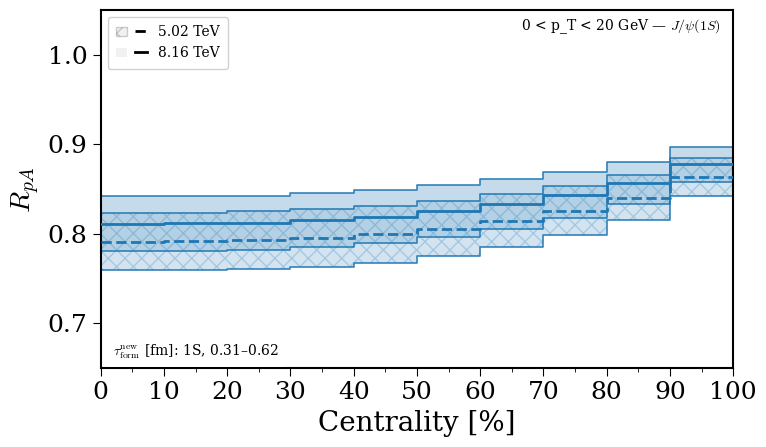

In [157]:
compare_energy(states=("jpsi_1S",), model="Pert", form="new", xcol="Cent",
               note="0 < p_T < 20 GeV", ylim=(0.65,1.05),
               save=outdir/"vsCent_energycmp_jpsi_pert.pdf")

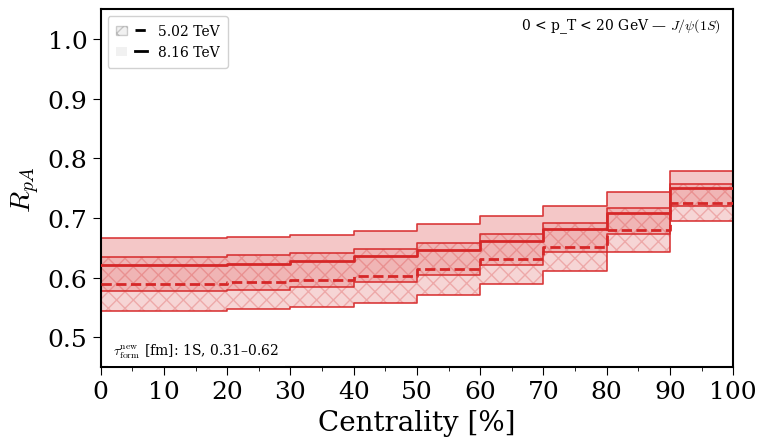

In [158]:
compare_energy(states=("jpsi_1S",), model="NPWLC", form="new", xcol="Cent",
               note="0 < p_T < 20 GeV", ylim=(0.45,1.05),
               save=outdir/f"vsCent_energycmp_jpsi_tau.pdf")

In [159]:
# compare_models(states=("jpsi_1S","psi_2S"), energy=8.16, form="old", xcol="Cent",
#                note=r"$\sqrt{s_{NN}}=8.16$ TeV, $\tau$=old, $0<p_T<20$ GeV",
#                ylim=(0.55,1.00), save=outdir/"vsCent_modelcmp_jpsi_1S_psi2S_old.pdf")

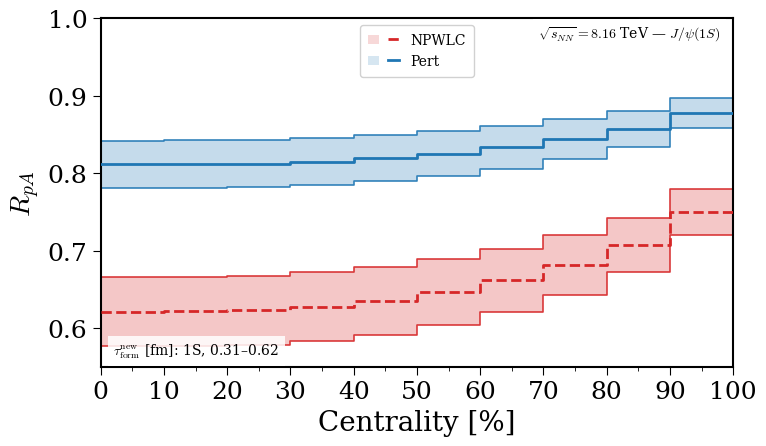

In [135]:
compare_models(states=("jpsi_1S",), energy=8.16, form="new", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV",
               ylim=(0.55,1.00), save=outdir/"vsCent_modelcmp_jpsi_1S.pdf")

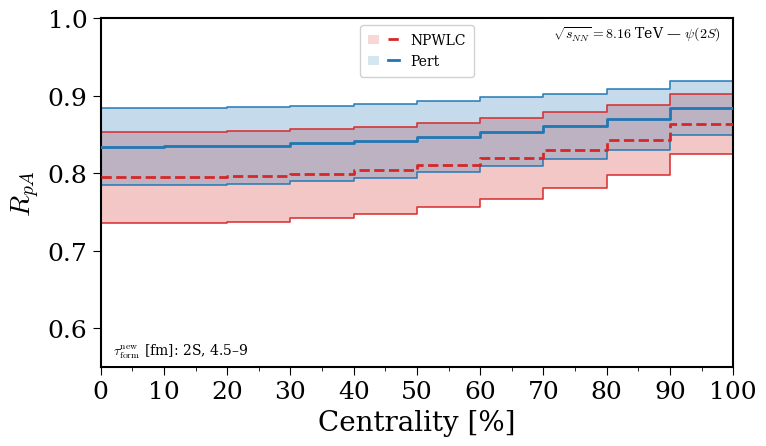

In [136]:
compare_models(states=("psi_2S",), energy=8.16, form="new", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV",
               ylim=(0.55,1.00), save=outdir/"vsCent_modelcmp_psi2S.pdf")

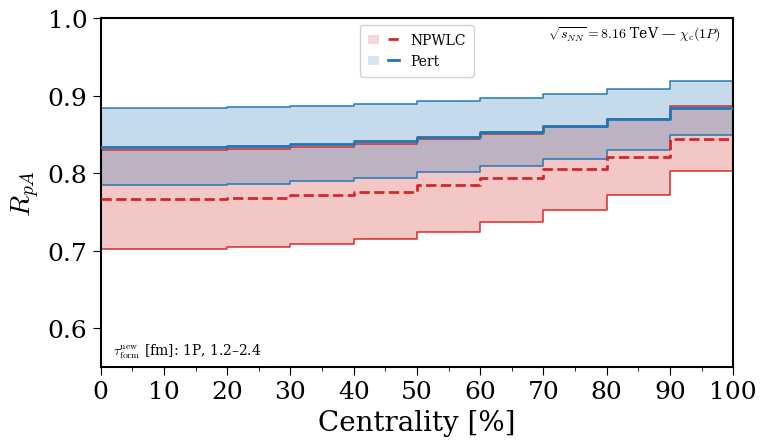

In [137]:
compare_models(states=("chicJ_1P",), energy=8.16, form="new", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV",
               ylim=(0.55,1.00), save=outdir/"vsCent_modelcmp_chi1p.pdf")

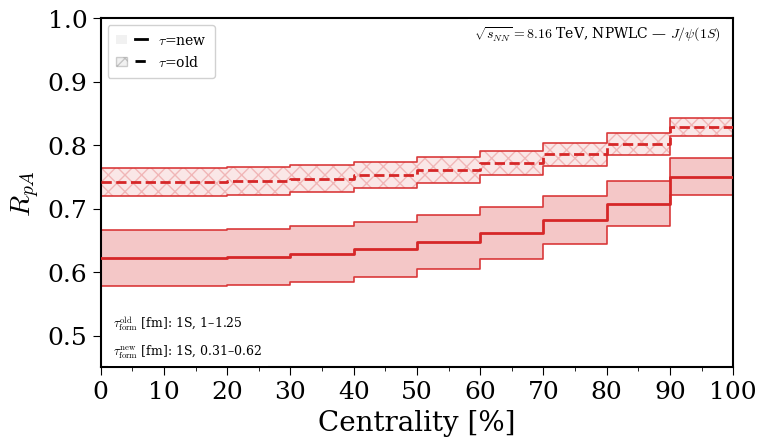

In [138]:
compare_tauform(states=("jpsi_1S",), energy=8.16, model="NPWLC", xcol="Cent",
                note=r"$\sqrt{s_{NN}}=8.16$ TeV, NPWLC",
                ylim=(0.45,1.00), save=outdir/"vsCent_taucmp_jpsi.pdf")

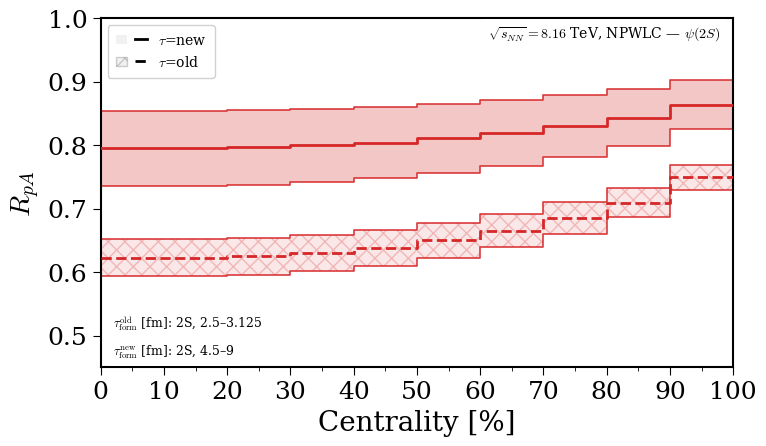

In [139]:
compare_tauform(states=("psi_2S",), energy=8.16, model="NPWLC", xcol="Cent",
                note=r"$\sqrt{s_{NN}}=8.16$ TeV, NPWLC",
                ylim=(0.45,1.00), save=outdir/"vsCent_taucmp_psi2s.pdf")

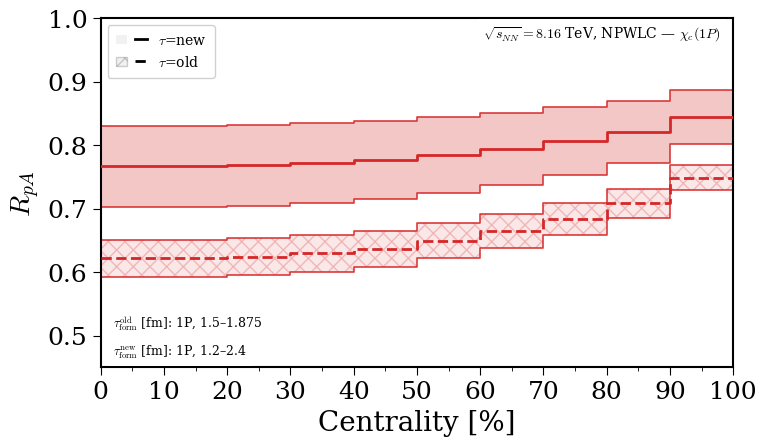

In [140]:
compare_tauform(states=("chicJ_1P",), energy=8.16, model="NPWLC", xcol="Cent",
                note=r"$\sqrt{s_{NN}}=8.16$ TeV, NPWLC",
                ylim=(0.45,1.00), save=outdir/"vsCent_taucmp_chi1p.pdf")

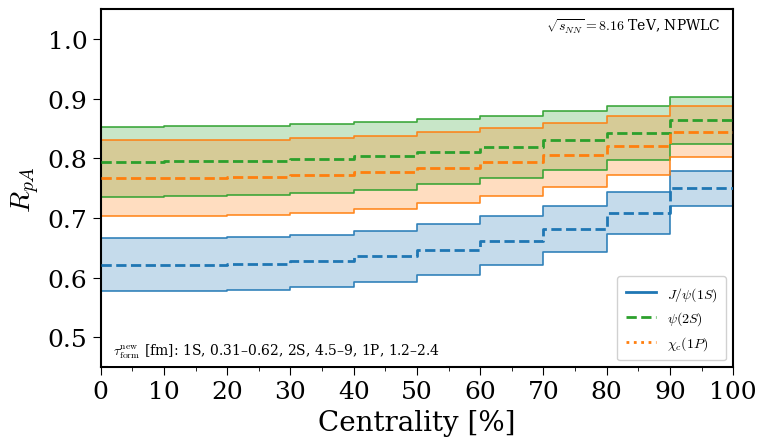

In [141]:
compare_states(states=("jpsi_1S","psi_2S","chicJ_1P"),
               energy=8.16, model="NPWLC", form="new", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV, NPWLC",
               ylim=(0.45,1.05), save=outdir/"vsCent_statecmp_8TeV_NPWLC_new.pdf")

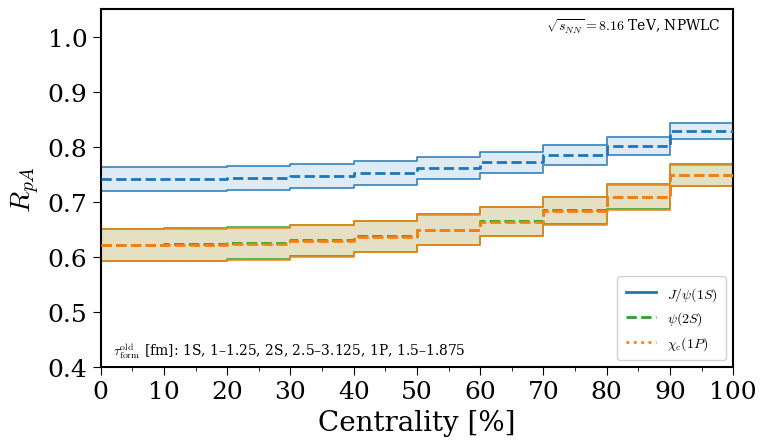

In [142]:
compare_states(states=("jpsi_1S","psi_2S","chicJ_1P"),
               energy=8.16, model="NPWLC", form="old", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV, NPWLC",
               ylim=(0.40,1.05), save=outdir/"vsCent_statecmp_8TeV_NPWLC_old.pdf")

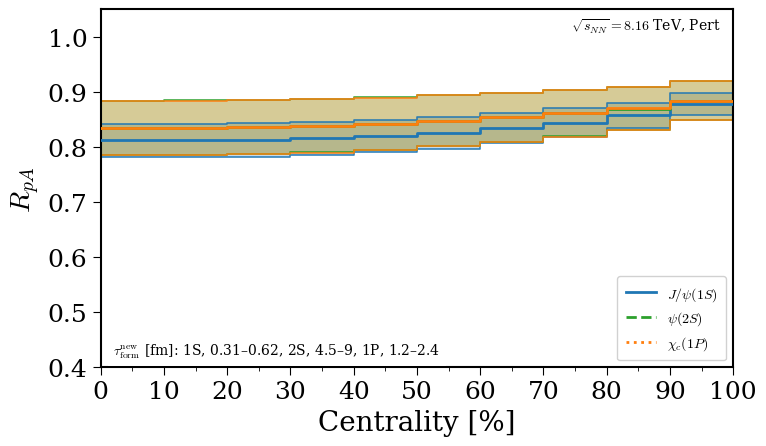

In [143]:
compare_states(states=("jpsi_1S","psi_2S","chicJ_1P"),
               energy=8.16, model="Pert", form="new", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV, Pert",
               ylim=(0.40,1.05), save=outdir/"vsCent_statecmp_8TeV_Pert_new.pdf")

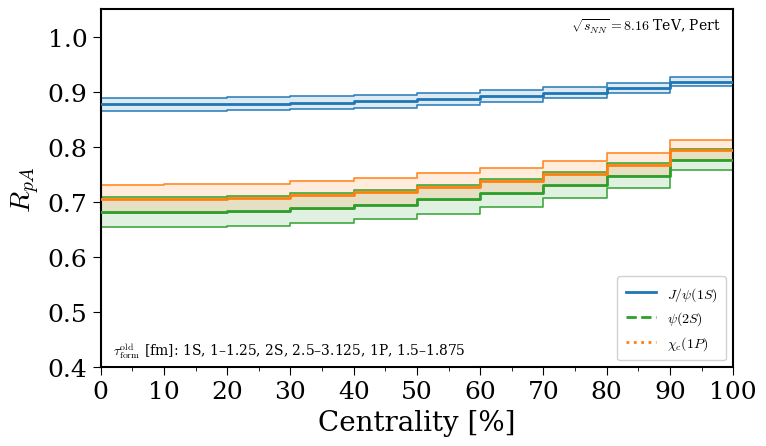

In [144]:
compare_states(states=("jpsi_1S","psi_2S","chicJ_1P"),
               energy=8.16, model="Pert", form="old", xcol="Cent",
               note=r"$\sqrt{s_{NN}}=8.16$ TeV, Pert",
               ylim=(0.40,1.05), save=outdir/"vsCent_statecmp_8TeV_Pert_old.pdf")

## $R_{pA}$ vs Rapidity

In [189]:
# combos_energy = pick(present, model="NPWLC", form="new")
# grid_y(states=("jpsi_1S",), combos=combos_energy, ylim=(0.40,1.05),
#        save=outdir/"grid_y_energycmp_jpsi.pdf")

In [188]:
# combos_model = pick(present, energy=8.16, form="new")
# grid_y(states=("jpsi_1S",), combos=combos_model, ylim=(0.40,1.05),
#        save=outdir/"grid_y_modelcmp_jpsi.pdf")

In [187]:
# combos_tau = pick(present, energy=8.16, model="Pert")
# grid_y(states=("psi_2S",), combos=combos_tau, ylim=(0.45,1.05),
#        save=outdir/"grid_y_taucmp_psi2S_Pert.pdf")

In [168]:
# combos_tau = pick(present, energy=8.16, model="NPWLC")
# grid_y(states=("psi_2S",), combos=combos_tau, ylim=(0.45,1.05),
#        save=outdir/"grid_y_taucmp_psi2S.pdf")

In [186]:
# combos_tau = pick(present, energy=8.16, model="NPWLC")
# grid_y(states=("jpsi_1S",), combos=combos_tau, ylim=(0.45,1.05),
#        save=outdir/"grid_y_taucmp_jpsi.pdf")

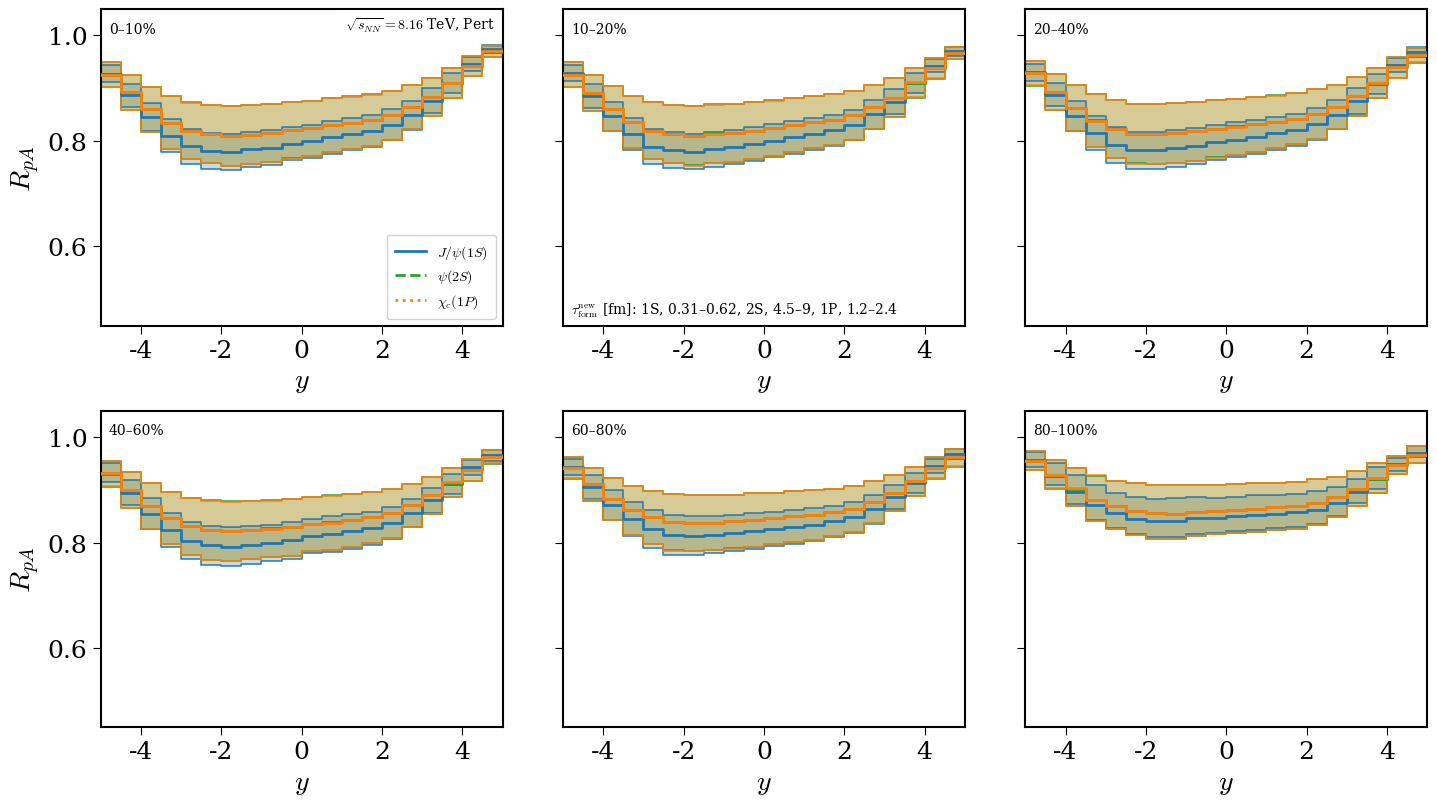

In [190]:
combos_fixed = pick(present, energy=8.16, model="Pert", form="new")
grid_y(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed, legend_kind="states",
       ylim=(0.45,1.05), color_by="state",
       save=outdir/"grid_y_statecmp_8TeV_Pert_new.pdf")

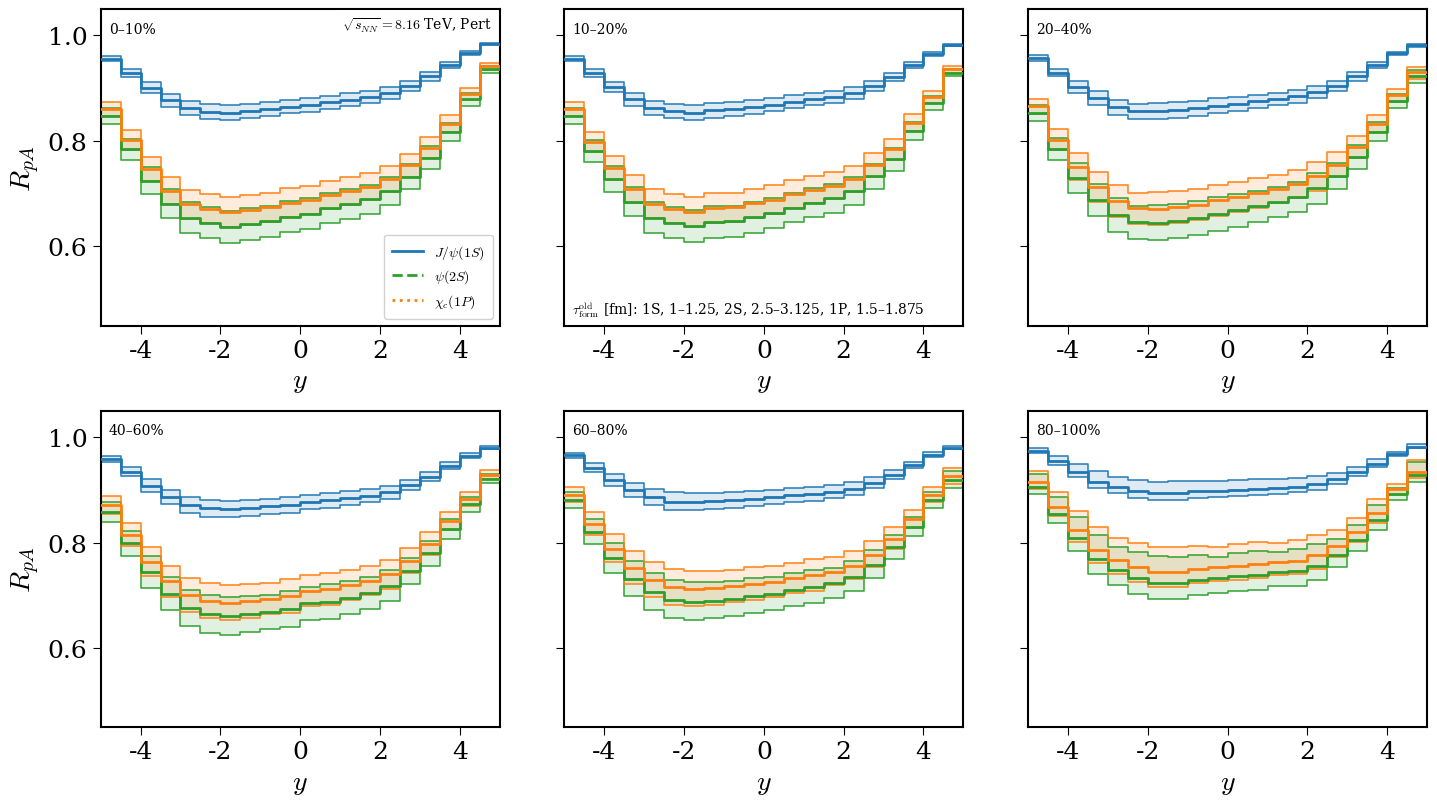

In [169]:
combos_fixed = pick(present, energy=8.16, model="Pert", form="old")
grid_y(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed, legend_kind="states",
       ylim=(0.45,1.05), color_by="state",
       save=outdir/"grid_y_statecmp_8TeV_Pert_old.pdf")

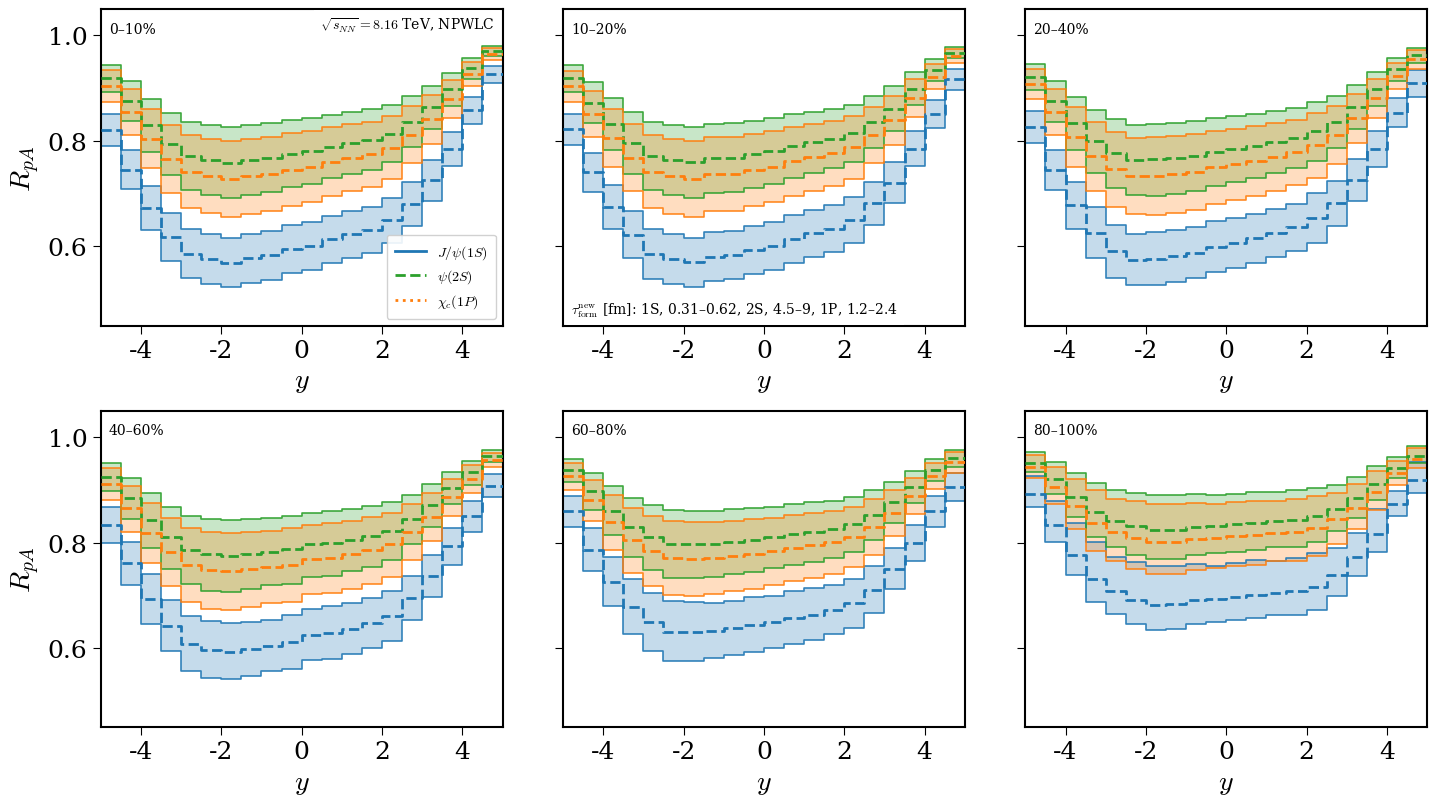

In [194]:
combos_fixed = pick(present, energy=8.16, model="NPWLC", form="new")
grid_y(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed, legend_kind="states",
       ylim=(0.45,1.05), color_by="state",
       save=outdir/"grid_y_statecmp_8TeV_NPWLC_new.pdf")

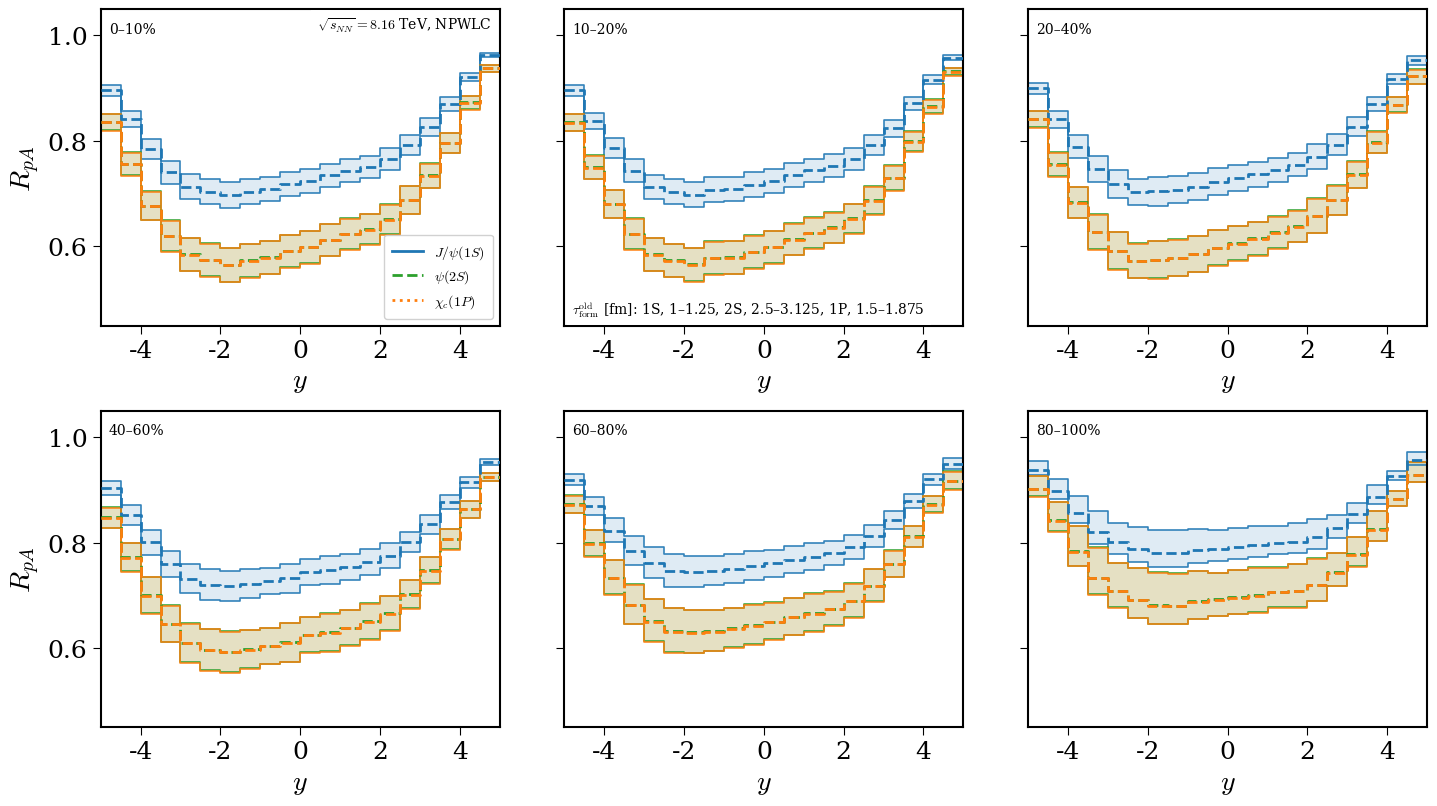

In [195]:
combos_fixed = pick(present, energy=8.16, model="NPWLC", form="old")
grid_y(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed, legend_kind="states",
       ylim=(0.45,1.05), color_by="state",
       save=outdir/"grid_y_statecmp_8TeV_NPWLC_old.pdf")

In [193]:
# combos_fixed = pick(present, energy=8.16, model="NPWLC", form="new")
# grid_y(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed, legend_kind="both",
#        ylim=(0.45,1.05), color_by="state",
#        save=outdir/"grid_y_statecmp_8TeV_NPWLC_new.pdf")

## $R_{pA}$ vs Transverse Momentum

In [174]:
# combos_energy = pick(present, model="NPWLC", form="new")
# grid_pt(states=("jpsi_1S",), combos=combos_energy, which_y="forward", ylim=(0.45,1.05),
#         save=outdir/"grid_pT_forward_energycmp_jpsi.pdf")

In [177]:
# # Model comparison at forward rapidity
# combos_model = pick(present, energy=8.16, form="new")  # NPWLC & Pert
# grid_pt(states=("jpsi_1S",), combos=combos_tau, which_y="central", ylim=(0.45,1.05),
#        save=outdir/"grid_pT_central_taucmp_jpsi_psi2S.pdf")

In [176]:
# combos_fixed = pick(present, energy=8.16, model="Pert", form="new")
# grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="backward",
#        ylim=(0.45,1.05), color_by="state",
#        save=outdir/"grid_pT_backward_statecmp_8TeV_Pert_new.pdf")

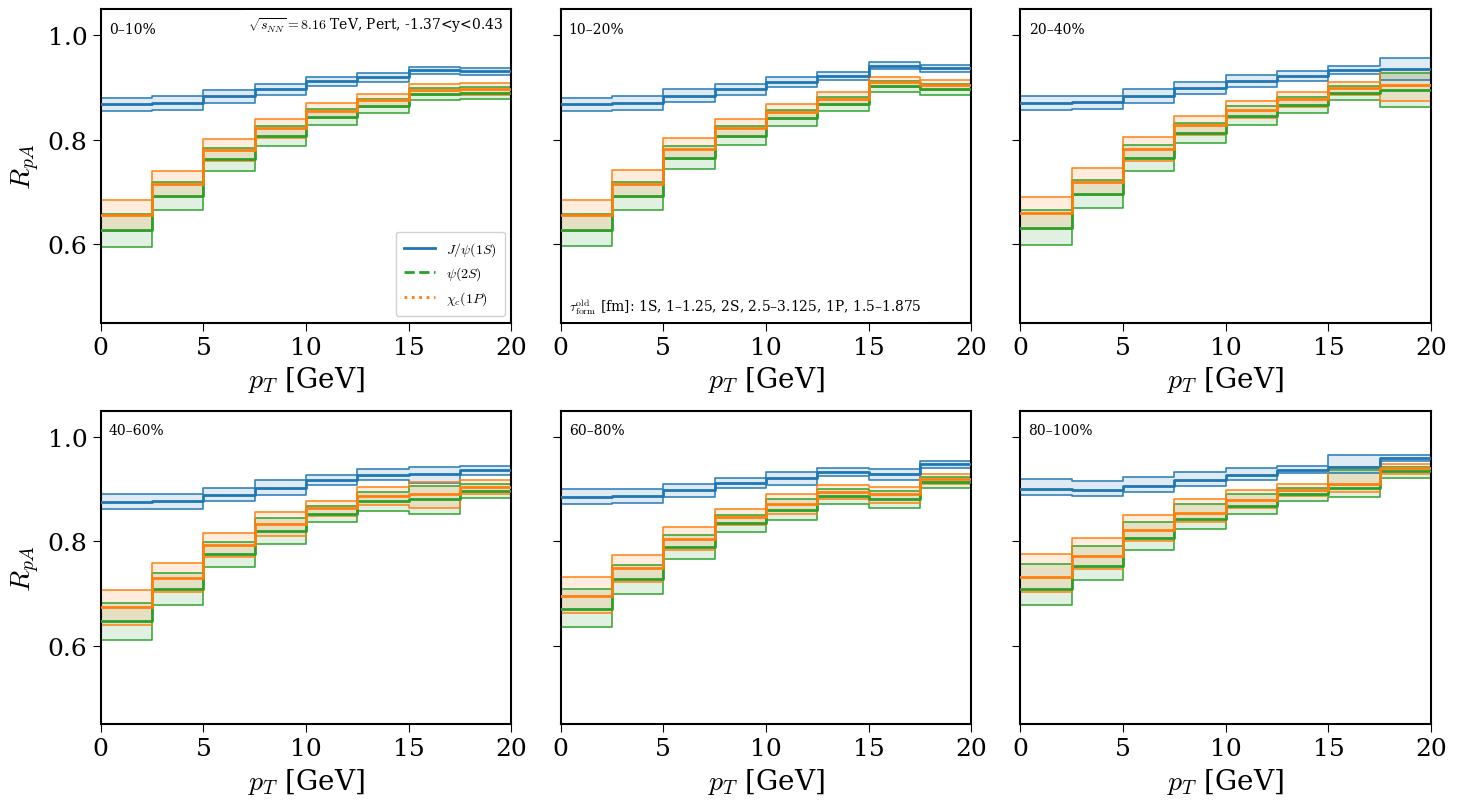

In [ ]:
combos_fixed = pick(present, energy=8.16, model="Pert", form="old")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="central",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_central_statecmp_8TeV_Pert_old.pdf")

combos_fixed = pick(present, energy=8.16, model="Pert", form="new")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="states",which_y="central",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_central_statecmp_8TeV_Pert_new.pdf")

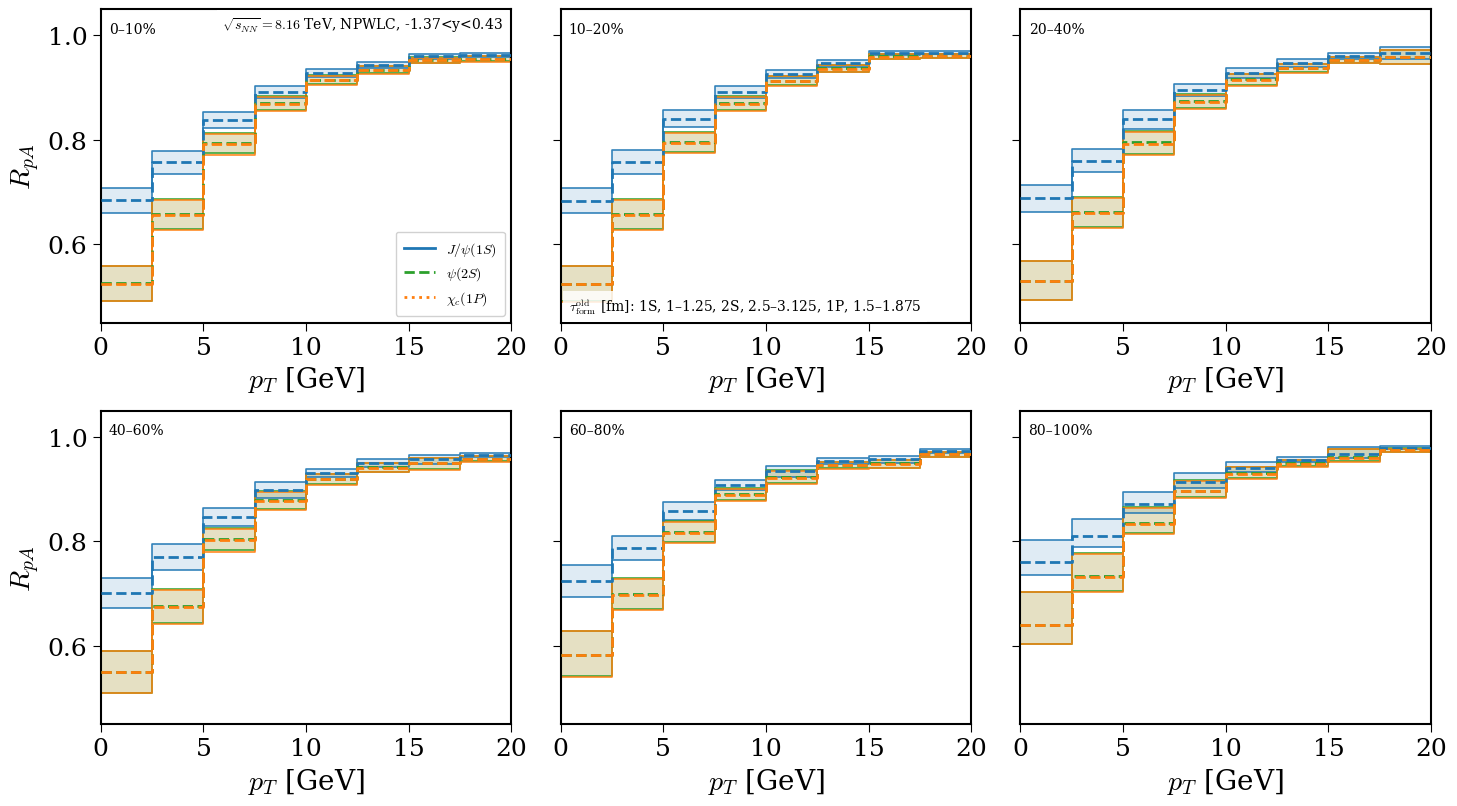

In [200]:
combos_fixed = pick(present, energy=8.16, model="NPWLC", form="old")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="central",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_central_statecmp_8TeV_NPWLC_old.pdf")

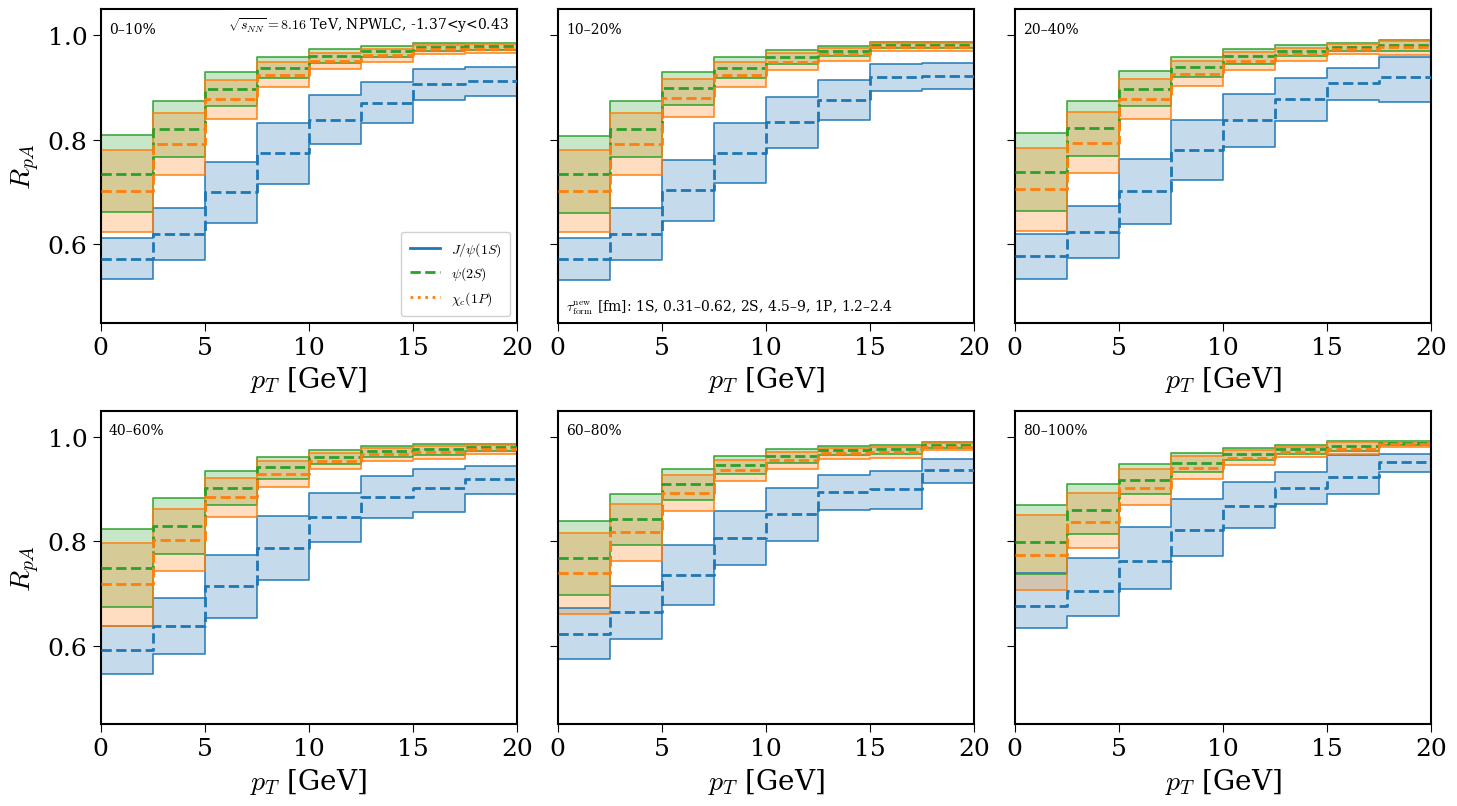

In [201]:
combos_fixed = pick(present, energy=8.16, model="NPWLC", form="new")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="states",which_y="central",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_central_statecmp_8TeV_NPWLC_new.pdf")

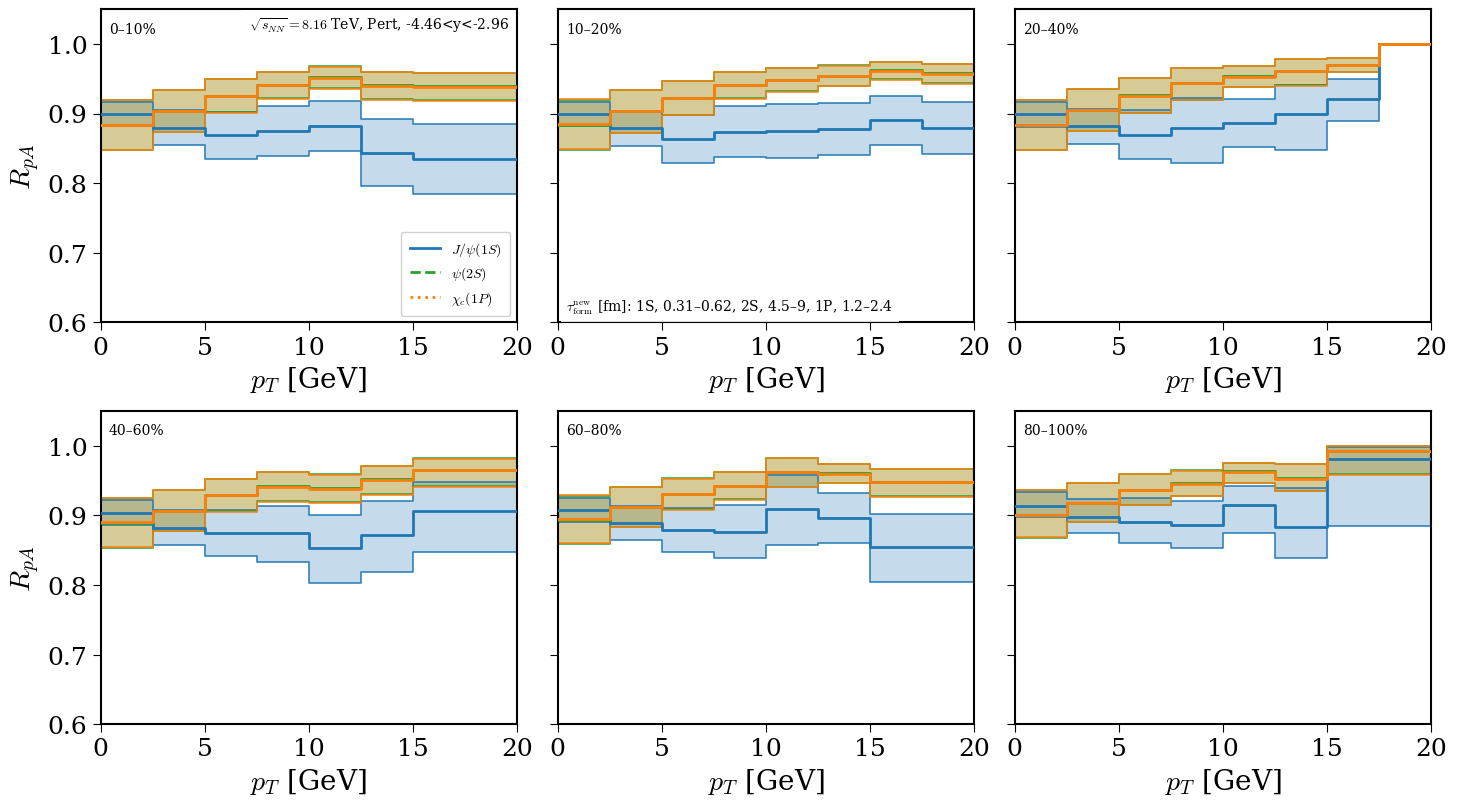

In [204]:
combos_fixed = pick(present, energy=8.16, model="Pert", form="old")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="backward",
       ylim=(0.6,1.05), color_by="state",
       save=outdir/"grid_pT_backward_statecmp_8TeV_Pert_old.pdf")

combos_fixed = pick(present, energy=8.16, model="Pert", form="new")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="backward",
       ylim=(0.6,1.05), color_by="state",
       save=outdir/"grid_pT_backward_statecmp_8TeV_Pert_new.pdf")

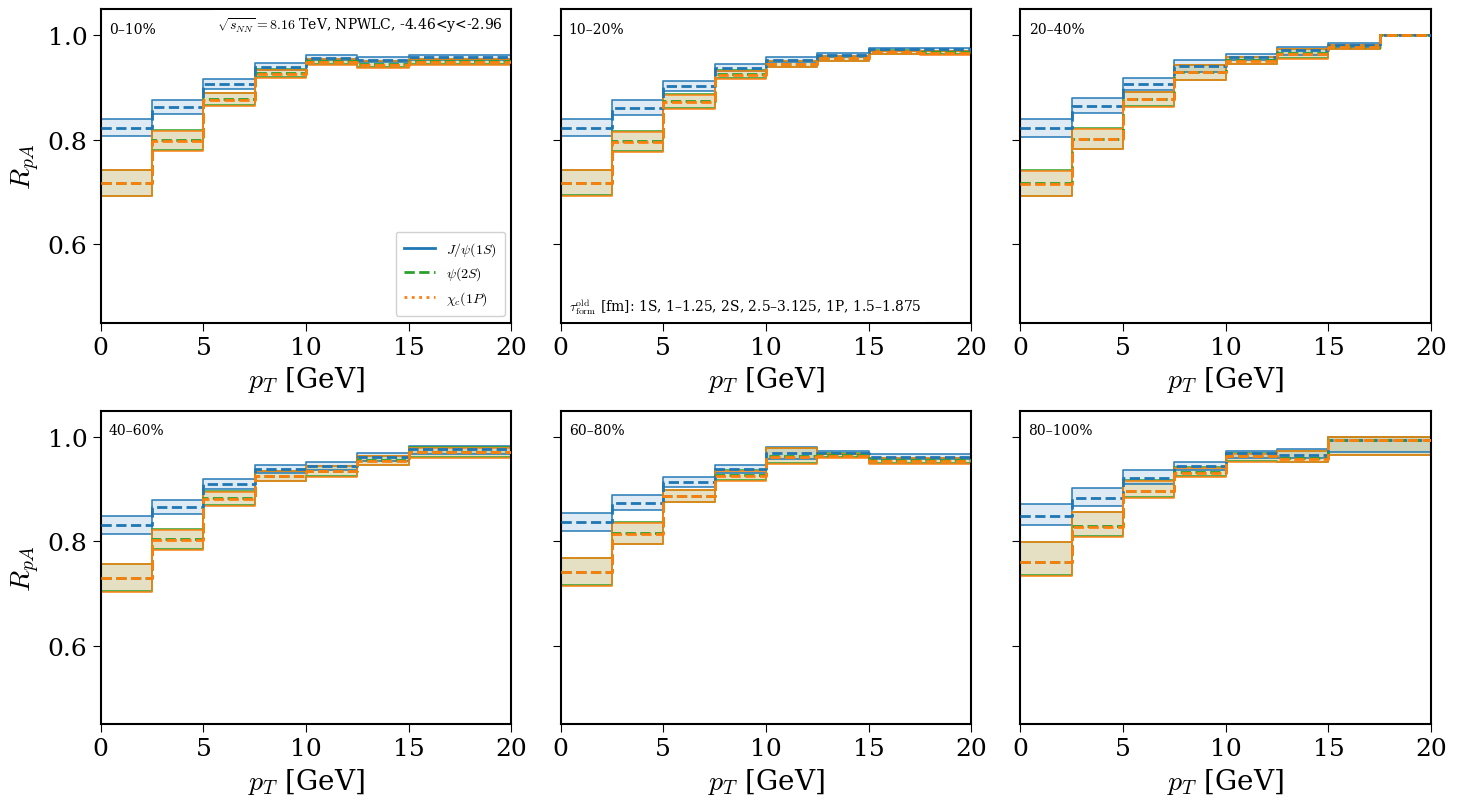

In [203]:
combos_fixed = pick(present, energy=8.16, model="NPWLC", form="new")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="backward",
       ylim=(0.45,1.05), color_by="state",
       save=outdir/"grid_pT_backward_statecmp_8TeV_NPWLC_new.pdf")

combos_fixed = pick(present, energy=8.16, model="NPWLC", form="old")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="backward",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_backward_statecmp_8TeV_NPWLC_old.pdf")

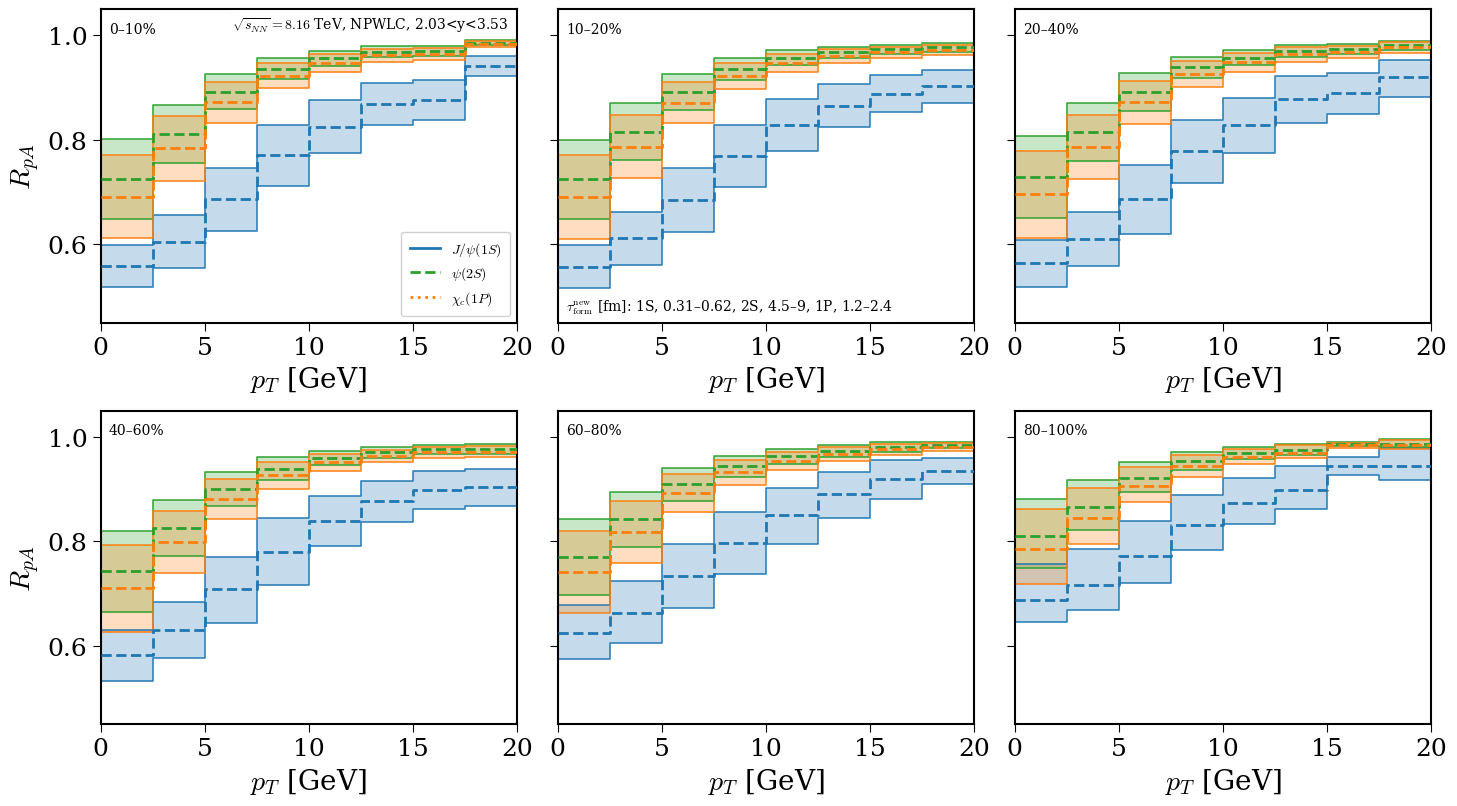

In [202]:
combos_fixed = pick(present, energy=8.16, model="NPWLC", form="old")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="forward",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_forward_statecmp_8TeV_NPWLC_old.pdf")


combos_fixed = pick(present, energy=8.16, model="NPWLC", form="new")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="forward",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_forward_statecmp_8TeV_NPWLC_new.pdf")

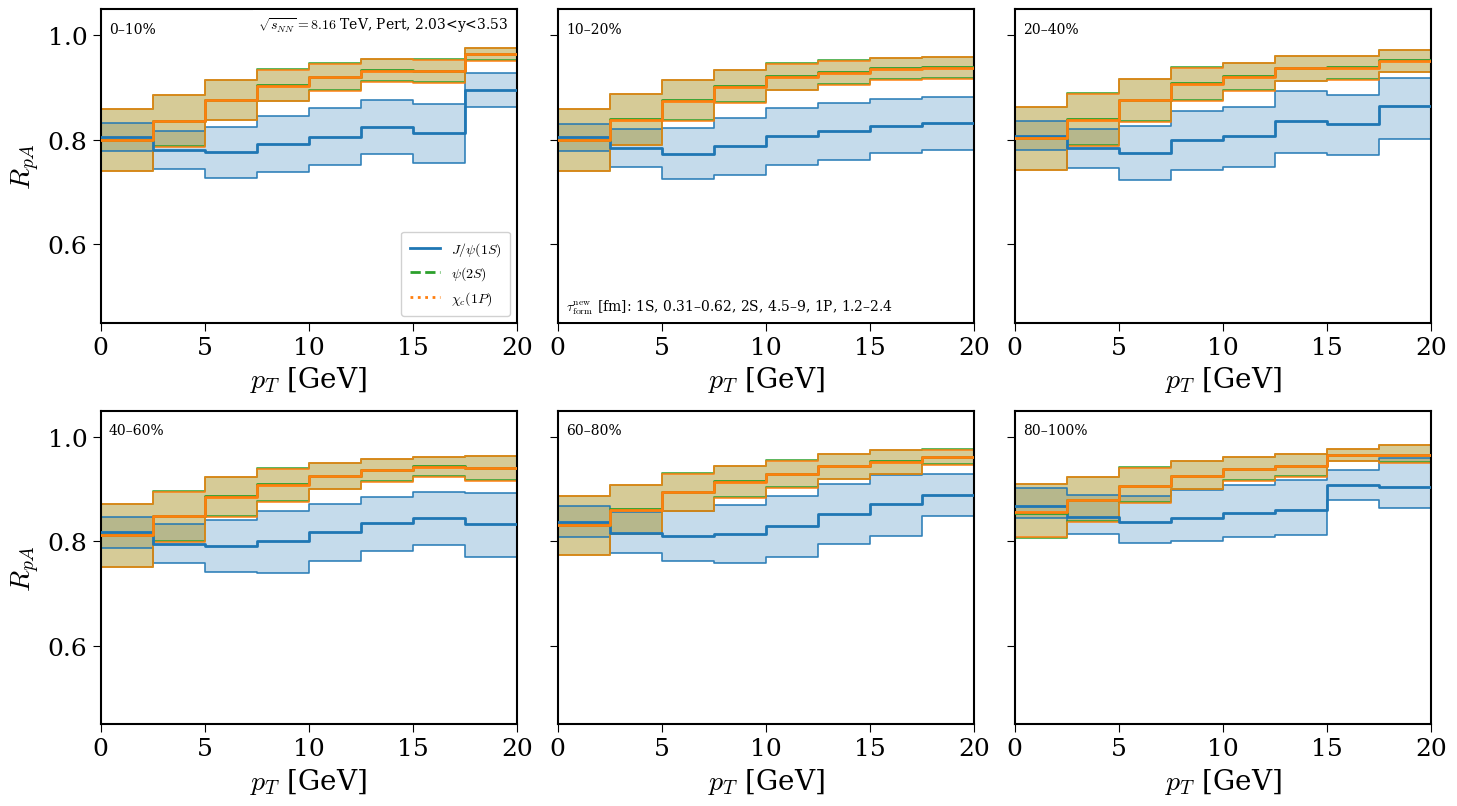

In [205]:
combos_fixed = pick(present, energy=8.16, model="Pert", form="old")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="forward",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_forward_statecmp_8TeV_Pert_old.pdf")


combos_fixed = pick(present, energy=8.16, model="Pert", form="new")
grid_pt(states=("jpsi_1S","psi_2S","chicJ_1P"), combos=combos_fixed,  legend_kind="both",which_y="forward",
       ylim=(0.45,1.05), color_by="state", 
       save=outdir/"grid_pT_forward_statecmp_8TeV_Pert_new.pdf")